# Learning Objectives

- Execute CRUD Ops on a vector database (Chroma) using `langchain` abstractions.
- Implement length-based chunking on a folder of documents.


# Setup

In [27]:
### Verify the numpy version. If the numpy version is not 2.3.4 (latest) then upgrade the same to avoid package conflict issues

!pip show numpy

Name: numpy
Version: 2.3.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2025, NumPy Developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are
 met:

     * Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.

     * Redistributions in binary form must reproduce the above
        copyright notice, this list of conditions and the following
        disclaimer in the documentation and/or other materials provided
        with the distribution.

     * Neither the name of the NumPy Developers nor the names of any
        contributors may be used to endorse or promote products derived
        from this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED

In [26]:
### Upgrading the package will restart the session. Also if there are errors kindly rerun the cell

!pip install numpy==2.3.4

In [1]:
### verify the version of chroma db package

!pip show chromadb

In [2]:
### Upgrade the package to avoid package conflict issues. Here we are installing version 1.3.4 of chromadb. It might ask to restart the session.

### If there are any errors in the output kindly rerun the cell

!pip install chromadb==1.3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.1 MB/

In [3]:
!pip show chromadb

Name: chromadb
Version: 1.3.4
Summary: Chroma.
Home-page: https://github.com/chroma-core/chroma
Author: 
Author-email: Jeff Huber <jeff@trychroma.com>, Anton Troynikov <anton@trychroma.com>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: bcrypt, build, grpcio, httpx, importlib-resources, jsonschema, kubernetes, mmh3, numpy, onnxruntime, opentelemetry-api, opentelemetry-exporter-otlp-proto-grpc, opentelemetry-sdk, orjson, overrides, posthog, pybase64, pydantic, pypika, pyyaml, rich, tenacity, tokenizers, tqdm, typer, typing-extensions, uvicorn
Required-by: 


In [9]:
### Install Imports. If error occurs rerun the cell

!pip install -q tiktoken==0.9.0 \
                pypdf==5.4.0 \
                langchain==0.3.20 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2

In [9]:
import time
import chromadb

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_core.documents import Document

from langchain_chroma import Chroma

from datetime import datetime
from google.colab import userdata

# Create

In this section, we will create a persistent Chroma vector database and populate this database with several records created from five years of Tesla 10-K's. Each record will contain - text from these documents, corresponding embedding vectors, metadata (e.g., source, page number).

## Download Raw Data

In [10]:
!unzip tesla-annual-reports.zip

Archive:  tesla-annual-reports.zip
   creating: tesla-annual-reports/
  inflating: tesla-annual-reports/tsla-20221231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20221231-gen.pdf  
  inflating: tesla-annual-reports/tsla-20231231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-20231231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10ka_20211231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10ka_20211231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20201231-gen.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20201231-gen.pdf  
  inflating: tesla-annual-reports/tsla-10k_20191231-gen_0.pdf  
  inflating: __MACOSX/tesla-annual-reports/._tsla-10k_20191231-gen_0.pdf  


## Chunking

The embedding model we will use to create the vector database is "jinaai/jina-embeddings-v3" from HuggingFace platform. This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

https://huggingface.co/jinaai/jina-embeddings-v3

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (8192 tokens for `text-embedding-3-small`). As a start, we will transform the pdf file into chunks of text that are no more than 512 characters long (this is a conservative choice from a token perspective and can be increased if results are not good). An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below). Note that the chunk size is number of tokens as counted by the Open AI embedding model.


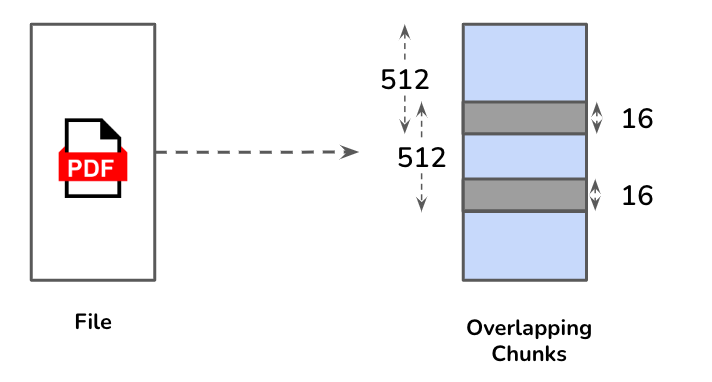

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

In [11]:
pdf_folder_location = "tesla-annual-reports"

In [12]:
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)

In [13]:
type(pdf_loader)

langchain_community.document_loaders.pdf.PyPDFDirectoryLoader

In [14]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In the code above we use the Open AI encoding scheme `cl100k_base` that was used by the embedding model of our choice - `text-embedding-3-small`.  

We can now load the PDF files from the folder and chunk them as follows (please note that this chunking process should take approximately 5 minutes):

In [15]:
tesla_10k_chunks = pdf_loader.load_and_split(text_splitter)

In [29]:
len(tesla_10k_chunks)

3337

We can inspect the contents of a page by accessing the `page_content` attribute.

In [17]:
print(tesla_10k_chunks[0])

page_content='UNITED	STATES
SECURITIES	AND	EXCHANGE	COMMISSION
Washington,	D.C.	20549
FORM	
10-K
(Mark	One)
x
ANNUAL	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	fiscal	year	ended	
December	31
,	2023
OR
o
TRANSITION	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	transition	period	from	_________	to	_________
Commission	File	Number:	
001-34756
Tesla,	Inc.
(Exact	name	of	registrant	as	specified	in	its	charter)
Delaware
91-2197729
(State	or	other	jurisdiction	of
incorporation	or	organization)
(I.R.S.	Employer
Identification	No.)
1	Tesla	Road
Austin
,	
Texas
78725
(Address	of	principal	executive	offices)
(Zip	Code)
(
512
)	
516-8177
(Registrant’s	telephone	number,	including	area	code)
Securities	registered	pursuant	to	Section	12(b)	of	the	Act:
Title	of	each	class
Trading	Symbol(s)
Name	of	each	exchange	on	which	registered
Common	stock
TSLA
The	Nasdaq	Global	Select	Market
Securities	registered	pursuant	to	Section

In [18]:
print(tesla_10k_chunks[0].page_content)

UNITED	STATES
SECURITIES	AND	EXCHANGE	COMMISSION
Washington,	D.C.	20549
FORM	
10-K
(Mark	One)
x
ANNUAL	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	fiscal	year	ended	
December	31
,	2023
OR
o
TRANSITION	REPORT	PURSUANT	TO	SECTION	13	OR	15(d)	OF	THE	SECURITIES	EXCHANGE	ACT	OF	1934
For	the	transition	period	from	_________	to	_________
Commission	File	Number:	
001-34756
Tesla,	Inc.
(Exact	name	of	registrant	as	specified	in	its	charter)
Delaware
91-2197729
(State	or	other	jurisdiction	of
incorporation	or	organization)
(I.R.S.	Employer
Identification	No.)
1	Tesla	Road
Austin
,	
Texas
78725
(Address	of	principal	executive	offices)
(Zip	Code)
(
512
)	
516-8177
(Registrant’s	telephone	number,	including	area	code)
Securities	registered	pursuant	to	Section	12(b)	of	the	Act:
Title	of	each	class
Trading	Symbol(s)
Name	of	each	exchange	on	which	registered
Common	stock
TSLA
The	Nasdaq	Global	Select	Market
Securities	registered	pursuant	to	Section	12(g)	of	the	

## Database Creation

We can now add the document chunks to a collection. Vector databases can hold multiple collections at the same time.

In [19]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

We begin by instantiating the embedding model and the persistent vector store. Note that once indexed the vector store could be downloaded and used as a standalone database.

In [20]:
### Documentation link - https://api.python.langchain.com/en/latest/embeddings/langchain_community.embeddings.huggingface.HuggingFaceEmbeddings.html

from langchain_community.embeddings import HuggingFaceEmbeddings

In [21]:
!pip install -U sentence-transformers

In [28]:
### Before running the command ensure the numpy version is 2.3.4. If not then upgrade numpy as per previous steps in notebook.
### Then do not restart the notebook. If you restart then you will loose all loaded variables. Just click Cancel instad of Restart


embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
### Below are few other embedding models from HuggingFace

# embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


# from langchain_community.embeddings.sentence_transformer import (
#     SentenceTransformerEmbeddings
# )
# embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

ImportError: Could not import sentence_transformers python package. Please install it with `pip install sentence-transformers`.

In [30]:
chromadb_client = chromadb.PersistentClient(
    path="./tesla_db"
)

We can ping the database client to check if the connection is alive like so:

In [31]:
chromadb_client.heartbeat()

1765392234156073834

At the moment the database is empty (i.e., no collections or records).

In [32]:
chromadb_client.count_collections()

0

Let us now create a collection using this persistent Chroma client.

In [33]:
vectorstore = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

We can check if the collection (currently empty) is created, as follows:

In [38]:
chromadb_client.count_collections()

1

In [39]:
chromadb_client.list_collections()

['tesla-10k-2019-to-2023']

We can now add documents to the Tesla 10-K collection we previously created in the vector store in batches. It's important to actively manage the number of chunks sent to the Azure OpenAI API to comply with its rate limits. In the following code, we batch 500 chunks to send to the API at a time, pausing execution for 30 seconds afterward. The exact number of chunks that can be embedded at once and the required waiting time depend on the rate limits set by the API.

In [36]:
i = 0 # Initialize the starting index for the chunks

while i < len(tesla_10k_chunks): # Iterate while the index is less than the total number of chunks
    vectorstore.add_documents( # Add documents to the vector store in batches of 500
        documents=tesla_10k_chunks[i:i+500], # Get the current batch of 500 chunks
        ids=["text_" + str(i) for i in range(i, i+500)] # Assign unique IDs to each chunk in the batch
    )

    i += 500 # Increment the index by 500 to move to the next batch
    time.sleep(30) # Pause for 30 seconds to avoid rate limiting issues with the vector store

# Read

Once the database is populated, entries in the database can be accessed by pointing a new Chroma instance (we are calling it `vectorstore_persisted` to differentiate create and read operations) to the directory where the documents were persisted.

In [37]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

There are two valuable types of vector database access:

1. Inspecting individual records.
2. Retrieving relevant records based on a user query.

Let us look at each in turn.

## Inspecting individual records

To inspect individual collection, we retrieve the collection and access individual records within the collection as follows:

In [40]:
collection = chromadb_client.get_collection(tesla_10k_collection)

In [41]:
# Count the number of records in the collection
collection.count()

3337

In [42]:
# Inspect the first 10 records
collection.peek()

{'ids': ['text_0',
  'text_1',
  'text_2',
  'text_3',
  'text_4',
  'text_5',
  'text_6',
  'text_7',
  'text_8',
  'text_9'],
 'embeddings': array([[ 0.01588889,  0.01084786, -0.04188821, ..., -0.03903174,
         -0.09404278, -0.03011507],
        [-0.00479784, -0.05969273, -0.02785683, ...,  0.00042073,
         -0.06608372, -0.00445146],
        [ 0.00558051, -0.00269025, -0.00050927, ..., -0.01328826,
         -0.08201089, -0.03411441],
        ...,
        [ 0.02619914, -0.01644191, -0.01376775, ..., -0.04979259,
         -0.0525268 , -0.04122611],
        [ 0.02371938, -0.03511788, -0.02662268, ..., -0.03196923,
         -0.05608393, -0.02072164],
        [ 0.03447419, -0.004567  , -0.00429851, ..., -0.00648198,
         -0.04629047, -0.00765405]], shape=(10, 768)),
 'documents': ['UNITED\tSTATES\nSECURITIES\tAND\tEXCHANGE\tCOMMISSION\nWashington,\tD.C.\t20549\nFORM\t\n10-K\n(Mark\tOne)\nx\nANNUAL\tREPORT\tPURSUANT\tTO\tSECTION\t13\tOR\t15(d)\tOF\tTHE\tSECURITIES\tEXCHANGE\tAC

In [43]:
# tables / keys present in the vector DB
collection.peek().keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'included'])

In [44]:
# Inspect a specific record

collection.get(
    ids=['text_999']
)

{'ids': ['text_999'],
 'embeddings': None,
 'documents': ['gives\tnotice\tof\tits\tresignation\t(the\t“\nResignation\tEffective\tDate\n”),\tthen\tthe\tretiring\tAdministrative\tAgent\tmay,\ton\tbehalf\tof\tthe\n\t\nLenders\tand\tthe\tIssuing\tBanks,\tappoint\ta\tsuccessor\tAdministrative\tAgent\treasonably\tacceptable\tto\tthe\tBorrower\t(except\tthat\tthe\n\t\nBorrower’s\tconsent\tshall\tnot\tbe\trequired\tif\tan\tEvent\tof\tDefault\thas\toccurred\tand\tis\tcontinuing)\twhich\tshall\tbe\ta\tbank\twith\tan\toffice\n\t\nin\tNew\tYork,\tNew\tYork,\tor\tan\tAffiliate\tof\tany\tsuch\tbank.\t\tIf\tthe\tPerson\tserving\tas\tAdministrative\tAgent\tis\ta\tDefaulting\tLender\n\t\npursuant\tto\t\nclause\t(e)\n\tof\tthe\tdefinition\tthereof,\tthe\tRequired\tLenders\tmay,\tto\tthe\textent\tpermitted\tby\tapplicable\tlaw,\tby\tnotice\tin\n\t\nwriting\tto\tthe\tBorrower\tand\tsuch\tPerson,\tremove\tsuch\tPerson\tas\tAdministrative\tAgent\tand,\tin\tconsultation\twith\tthe\tBorrower,\n\t\nappoint\ta\

The output above shows that several pieces of metadata are automatically added by `langchain` during record creation. These include items such as `creationdate`, `source`, and `page`, among others.

## Retrieving relevant records

The primary function of the vector database we just created is to retrieve relevant records based on user queries. To facilitate this process, we implement a retriever that utilizes the query embeddings to query the database. It uses the HNSW algorithm to calculate the nearest neighbors for the query and returns the corresponding documents from the database.

In [45]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [46]:
user_query = "Automotive revenue in 2021?"

In [47]:
retriever.invoke(user_query)

[Document(id='text_120', metadata={'creationdate': '2024-01-29T11:11:14+00:00', 'creator': 'wkhtmltopdf 0.12.6', 'page': 38, 'page_label': '39', 'producer': 'Qt 5.15.2', 'source': 'tesla-annual-reports/tsla-20231231-gen.pdf', 'title': '', 'total_pages': 130}, page_content='2022\n2021\n$\n%\n$\n%\nAutomotive\tsales\n$\n78,509\t\n$\n67,210\t\n$\n44,125\t\n$\n11,299\t\n17\t\n%\n$\n23,085\t\n52\t\n%\nAutomotive\tregulatory\tcredits\n1,790\t\n1,776\t\n1,465\t\n14\t\n1\t\n%\n311\t\n21\t\n%\nAutomotive\tleasing\n2,120\t\n2,476\t\n1,642\t\n(356)\n(14)\n%\n834\t\n51\t\n%\nTotal\tautomotive\trevenues\n82,419\t\n71,462\t\n47,232\t\n10,957\t\n15\t\n%\n24,230\t\n51\t\n%\nServices\tand\tother\n8,319\t\n6,091\t\n3,802\t\n2,228\t\n37\t\n%\n2,289\t\n60\t\n%\nTotal\tautomotive\t&\tservices\tand\tother\tsegment\nrevenue\n90,738\t\n77,553\t\n51,034\t\n13,185\t\n17\t\n%\n26,519\t\n52\t\n%\nEnergy\tgeneration\tand\tstorage\tsegment\trevenue\n6,035\t\n3,909\t\n2,789\t\n2,126\t\n54\t\n%\n1,120\t\n40\t\n%\nTot

In [48]:
len(retriever.invoke(user_query))

5

# Update

We can also update any individual record on one or more fields associated with it like so:

In [50]:
record_index_for_update = 999

In [51]:
vectorstore_persisted.update_document(
    document_id='text_' + str(record_index_for_update),
    document=Document(
        page_content=tesla_10k_chunks[record_index_for_update].page_content,
        metadata={"creator": "johndoe"}
    )
)

In [53]:
# Inspect a specific record

collection.get(
    ids=['text_999']
)

{'ids': ['text_999'],
 'embeddings': None,
 'documents': ['gives\tnotice\tof\tits\tresignation\t(the\t“\nResignation\tEffective\tDate\n”),\tthen\tthe\tretiring\tAdministrative\tAgent\tmay,\ton\tbehalf\tof\tthe\n\t\nLenders\tand\tthe\tIssuing\tBanks,\tappoint\ta\tsuccessor\tAdministrative\tAgent\treasonably\tacceptable\tto\tthe\tBorrower\t(except\tthat\tthe\n\t\nBorrower’s\tconsent\tshall\tnot\tbe\trequired\tif\tan\tEvent\tof\tDefault\thas\toccurred\tand\tis\tcontinuing)\twhich\tshall\tbe\ta\tbank\twith\tan\toffice\n\t\nin\tNew\tYork,\tNew\tYork,\tor\tan\tAffiliate\tof\tany\tsuch\tbank.\t\tIf\tthe\tPerson\tserving\tas\tAdministrative\tAgent\tis\ta\tDefaulting\tLender\n\t\npursuant\tto\t\nclause\t(e)\n\tof\tthe\tdefinition\tthereof,\tthe\tRequired\tLenders\tmay,\tto\tthe\textent\tpermitted\tby\tapplicable\tlaw,\tby\tnotice\tin\n\t\nwriting\tto\tthe\tBorrower\tand\tsuch\tPerson,\tremove\tsuch\tPerson\tas\tAdministrative\tAgent\tand,\tin\tconsultation\twith\tthe\tBorrower,\n\t\nappoint\ta\

The output above indicates that the creator of record with id `text_999` is now updated.

# Delete

In [ ]:
# The following line deletes records and should be used with caution
# vectorstore.delete(ids=['text_996'])

# Next Steps

In the next step of the RAG workflow, we will query the database to retrieve relevant documents for user queries. With the vector database now created, you can download it and set up a new instance by directing it to the downloaded folder. This is necessary because Colab instances are ephemeral, meaning our current database only exists within the instance.

In [ ]:
!zip -r tesla_db.zip tesla_db

  adding: tesla_db/ (stored 0%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/ (stored 0%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/index_metadata.pickle (deflated 60%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/length.bin (deflated 83%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/data_level0.bin (deflated 10%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/header.bin (deflated 57%)
  adding: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/link_lists.bin (deflated 83%)
  adding: tesla_db/chroma.sqlite3 (deflated 66%)


We can now download the file: `tesla_db.zip` and use it in another Colab instance.

In [54]:
!zip -r /content/tesla_db.zip /content/tesla_db

  adding: content/tesla_db/ (stored 0%)
  adding: content/tesla_db/chroma.sqlite3 (deflated 66%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/ (stored 0%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/index_metadata.pickle (deflated 60%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/link_lists.bin (deflated 84%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/data_level0.bin (deflated 10%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/header.bin (deflated 57%)
  adding: content/tesla_db/f2a82edc-7809-48e8-ac42-72ab9b54b968/length.bin (deflated 83%)


<font size=6; color='blue'> **Happy Learning!** </font>
___